산업데이터사이언스학부 201904198 김윤범

In [3]:
pip install catboost

Note: you may need to restart the kernel to use updated packages.


In [4]:
import numpy as np
import pandas as pd

# EDA
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import scipy.stats
from scipy.stats import skew
from scipy.stats import spearmanr


데이터 설명, 한국에너지공단의 데이터(2개의 csv파일)

1)(12만개의 데이터)60개 건물들의 2020년 6월 1일부터 2020년 8월 24일까지의 데이터
 -1시간 단위로 제공
 -전력사용량(kWh)포함

2)60개 건물들의 2020년 8월 25일부터 2020년 8월 31일까지의 데이터
 -3시간 단위로 제공(강수량의 경우 6시간 단위로 제공, 예보데이터)
 -전력사용량(kWh) 미포함


변수 설명

건물 번호(1, 2, 3, …)
시간
전력사용량
기온
풍속
습도
강수량
일조량
비전기냉방설비운영 여부(전기가 아닌 가스로 전환하는 냉난방시스템), 0:없음, 1:있음.
태양광보유 여부, 0:없음, 1:있음.

In [5]:
#데이터 불러오기

train_df= pd.read_csv("E:\\kimybeom\\subject\\python\\train.csv", encoding = "cp949") 
test_df= pd.read_csv("E:\\kimybeom\\subject\\python\\test.csv", encoding = "cp949")
sub= pd.read_csv("E:\\kimybeom\\subject\\python\\sample_submission.csv")

In [6]:
# 변수이름 재설정

train_df.columns = ['num','datetime','target','temperature','windspeed','humidity','precipitation','insolation','nelec_cool_flag','solar_flag']
test_df.columns = ['num','datetime','temperature','windspeed','humidity','precipitation','insolation','nelec_cool_flag','solar_flag']

In [7]:
test_df.head(5)

,num,datetime,temperature,windspeed,humidity,precipitation,insolation,nelec_cool_flag,solar_flag
0,1,2020-08-25 00,27.8,1.5,74.0,0.0,0.0,NaN,NaN
1,1,2020-08-25 01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,2020-08-25 02,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,2020-08-25 03,27.3,1.1,78.0,NaN,0.0,NaN,NaN
4,1,2020-08-25 04,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10080 entries, 0 to 10079
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   num              10080 non-null  int64  
 1   datetime         10080 non-null  object 
 2   temperature      3360 non-null   float64
 3   windspeed        3360 non-null   float64
 4   humidity         3360 non-null   float64
 5   precipitation    1680 non-null   float64
 6   insolation       3360 non-null   float64
 7   nelec_cool_flag  2296 non-null   float64
 8   solar_flag       1624 non-null   float64
dtypes: float64(7), int64(1), object(1)
memory usage: 708.9+ KB


In [9]:
sns.set_style('dark')

In [10]:
eda_df = train_df.copy()

In [11]:
# "datetime"과 관련된 시간 변수 추가
eda_df['datetime'] = pd.to_datetime(eda_df['datetime'])
eda_df['hour'] = eda_df['datetime'].dt.hour
eda_df['weekday'] = eda_df['datetime'].dt.weekday
eda_df['date'] = eda_df['datetime'].dt.date
eda_df['day'] = eda_df['datetime'].dt.day
eda_df['month'] = eda_df['datetime'].dt.month
eda_df['weekend'] = eda_df['weekday'].isin([5,6]).astype(int)

요인 설정

1) 시간요인: 사람들이 출근하면 냉방을 이용하고(데이터의 계절이 여름인 점을 고려), 
    오후 9시가 되면 주점이 오픈을 하고 다양한 전력 소모가 발생한다. 
    주말이 되면 사무실 전력사용은 줄고, 카페나 식당 전력사용량이 증가한다. 이를 확인하는 시간변수(hour, weekday)

2) 기상요인: 날씨가 덥고 불쾌지수가 높으면 에어컨을 켜고, 
    비가 오고 바람이 세게 불면 집 밖으로 잘 나가지 않는 등, 기상은 사람의 행위에 영향을 준다.

2가지를 기준으로 분석을 실시할 예정


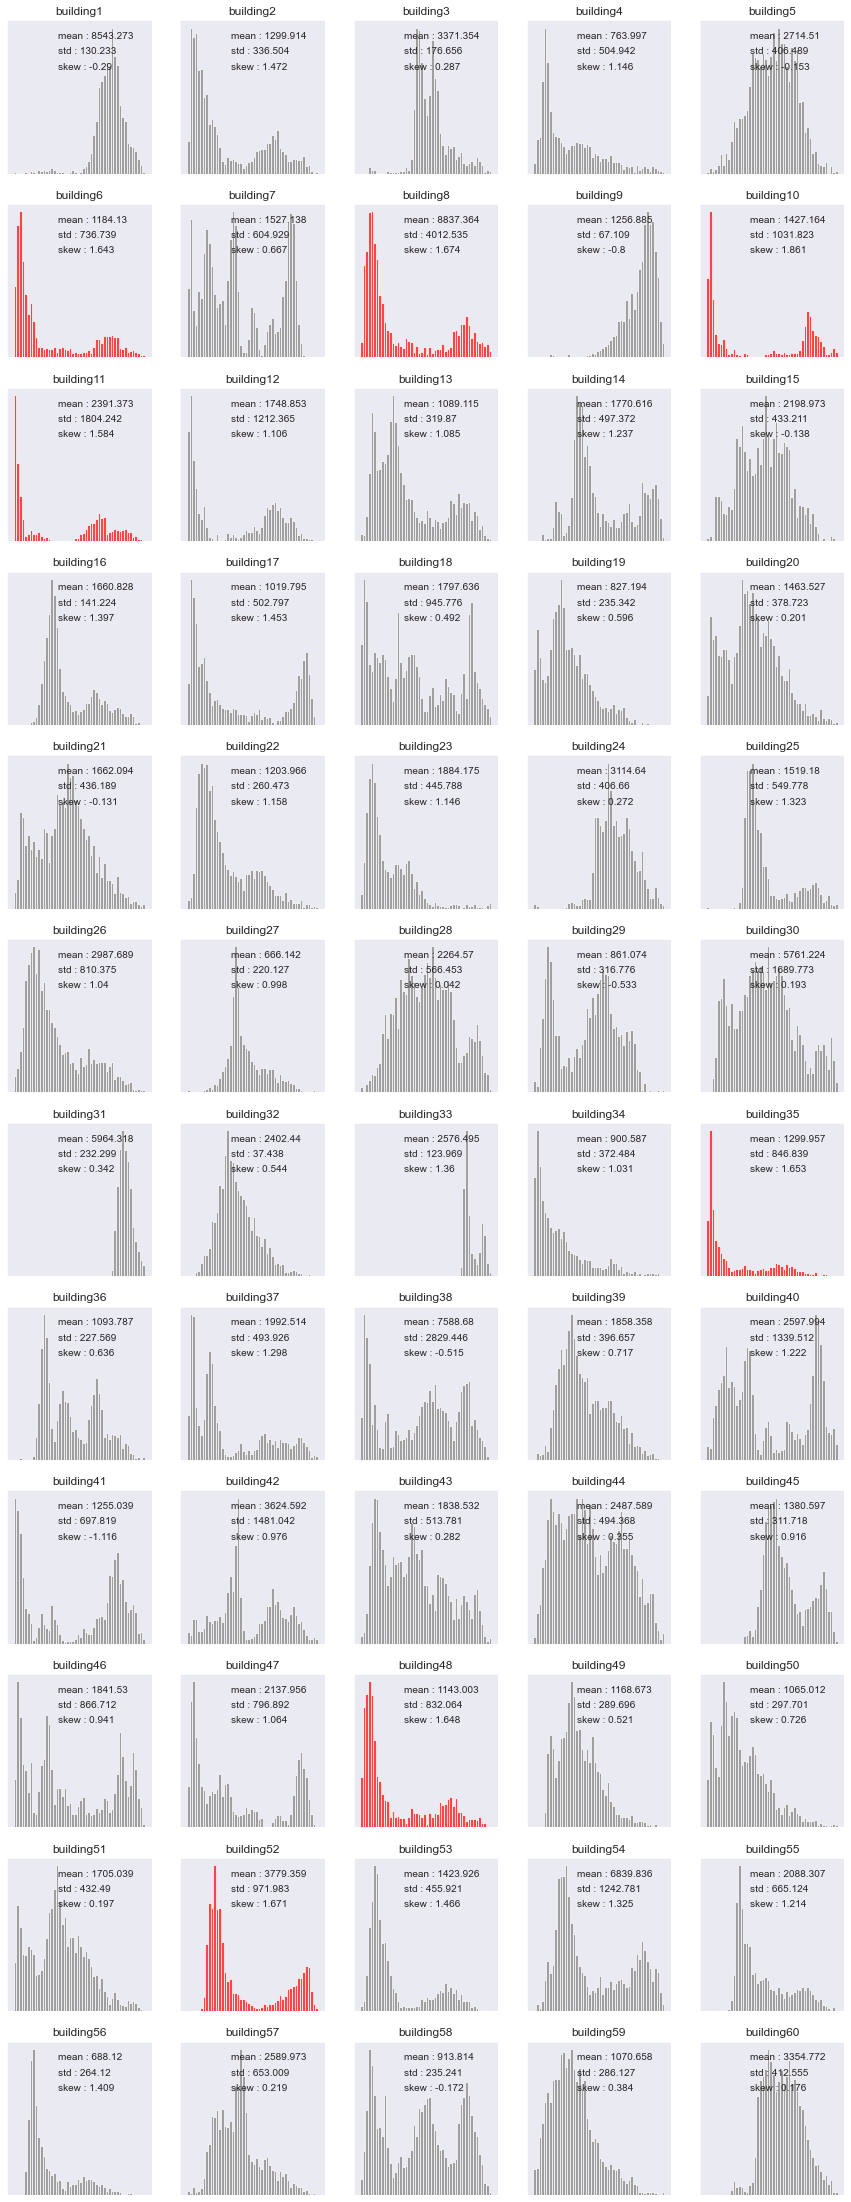

In [12]:
#에너지 사용 분포(평균(location), 표준편차(scale), 왜도(skewness))

fig = plt.figure(figsize = (15, 40))
for num in range(1,61):
    ax = plt.subplot(12, 5, num)
    energy = eda_df.loc[eda_df.num == num, 'target'].values
    mean = energy.mean().round(3)
    std = energy.std().round(3)
    skew = (3*(mean - np.median(energy))/energy.std()).round(3)
    if skew >= 1.5:
        plt.hist(energy, alpha = 0.7, bins = 50, color = 'red')
    elif skew <= -1.5:
        plt.hist(energy, alpha = 0.7, bins = 50, color = 'blue')
    else:
        plt.hist(energy, alpha = 0.7, bins = 50, color = 'gray')
    plt.title(f'building{num}')
    plt.xticks([])
    plt.yticks([])
    plt.xlabel('')
    plt.ylabel('')
    plt.text(0.35, 0.9, f'mean : {mean}',  ha='left', va='center', transform=ax.transAxes)
    plt.text(0.35, 0.8, f'std : {std}',  ha='left', va='center', transform=ax.transAxes)
    plt.text(0.35, 0.7, f'skew : {skew}',  ha='left', va='center', transform=ax.transAxes)

6, 8, 10, 11, 35, 48, 52 건물은 1.5이상의 왜도(비대칭도)를 보여 빨간색으로 표시된다.
이러한 특징을 가진 변수를 정규분포에 가깝게 만들어 주기 위해 변수에 log(로그)를 취해준다.
Log를 취해주게 되면 큰 숫자를 같은 비율의 작은 숫자로 만들어주며, 첨도(확률분포의 뾰족한 정도)와 왜도가 줄어들면서 정규성이 높아진다.
이는 분석의 정확도를 더 높일 수 있는 결과를 가져온다. 

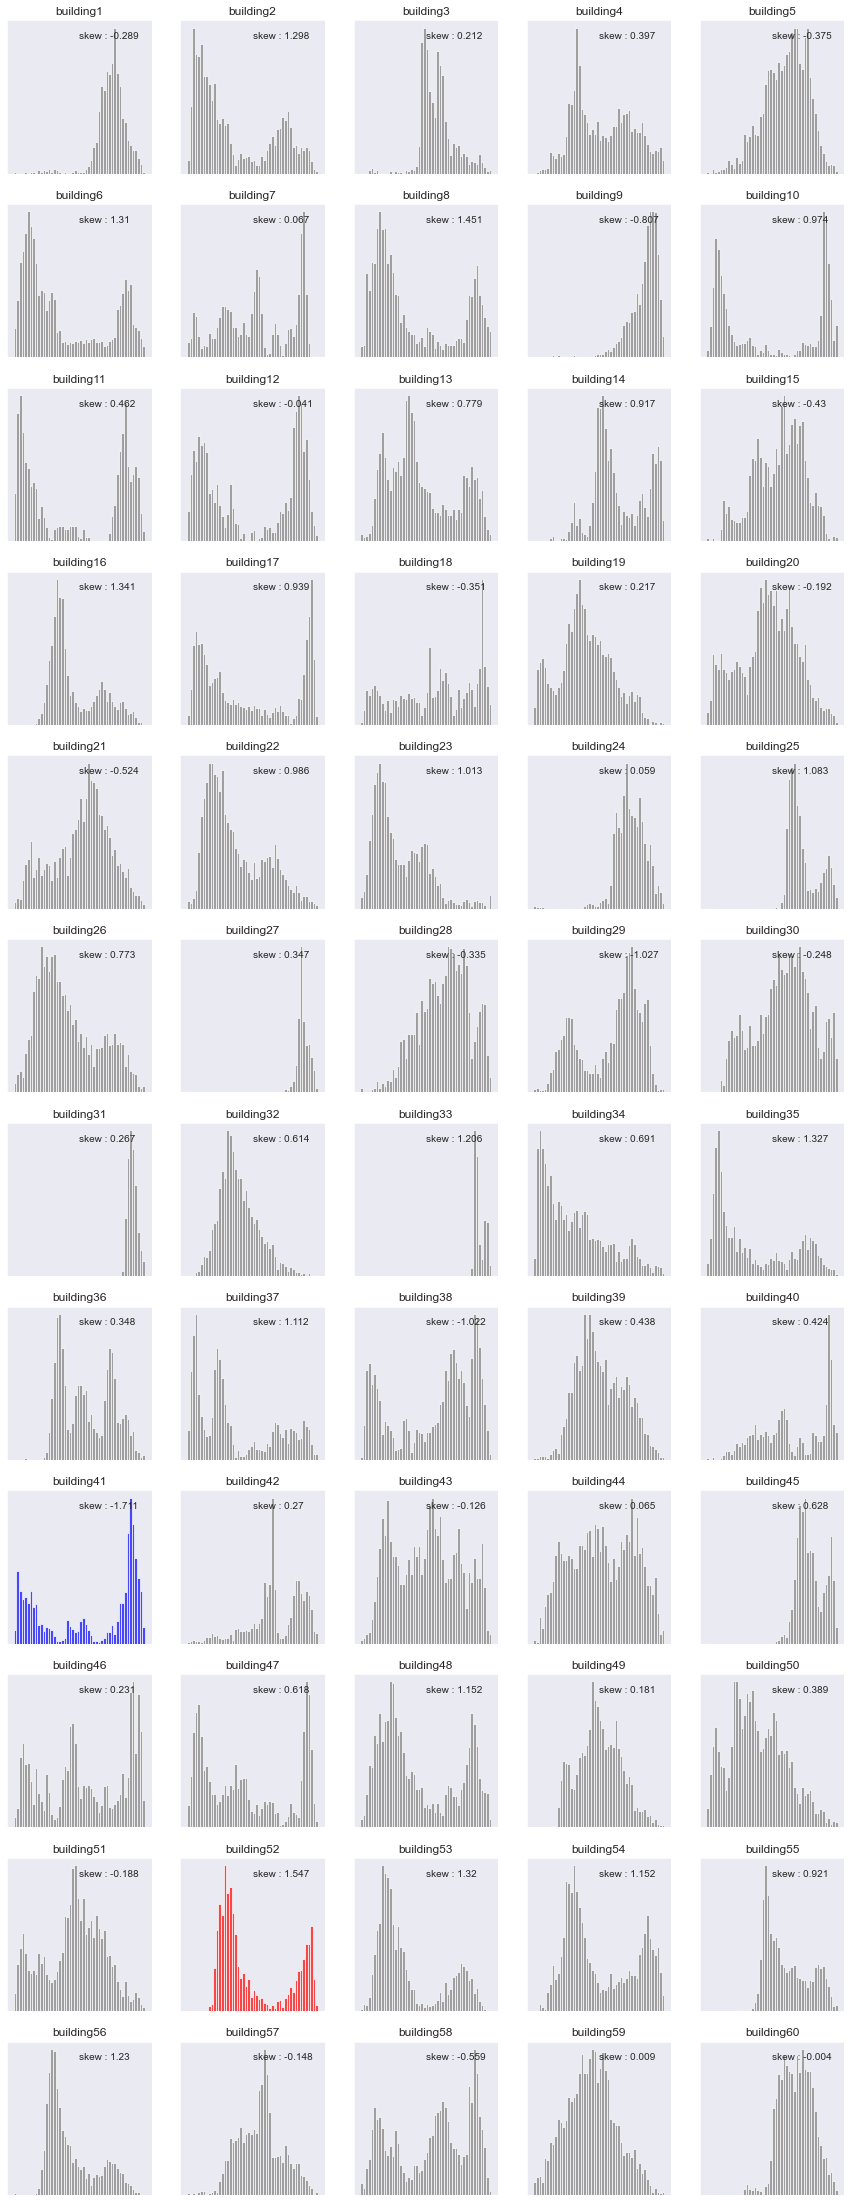

In [13]:
fig = plt.figure(figsize = (15, 40))
for num in range(1,61):
    ax = plt.subplot(12, 5, num)
    energy = np.log(1 + eda_df.loc[eda_df.num == num, 'target'].values)
    mean = energy.mean().round(3)
    std = energy.std().round(3)
    skew = (3*(mean - np.median(energy))/energy.std()).round(3)
    if skew >= 1.5:
        plt.hist(energy, alpha = 0.7, bins = 50, color = 'red')
    elif skew <= -1.5:
        plt.hist(energy, alpha = 0.7, bins = 50, color = 'blue')
    else:
        plt.hist(energy, alpha = 0.7, bins = 50, color = 'gray')
    plt.title(f'building{num}')
    plt.xticks([])
    plt.yticks([])
    plt.xlabel('')
    plt.ylabel('')
    plt.text(0.5, 0.9, f'skew : {skew}',  ha='left', va='center', transform=ax.transAxes)

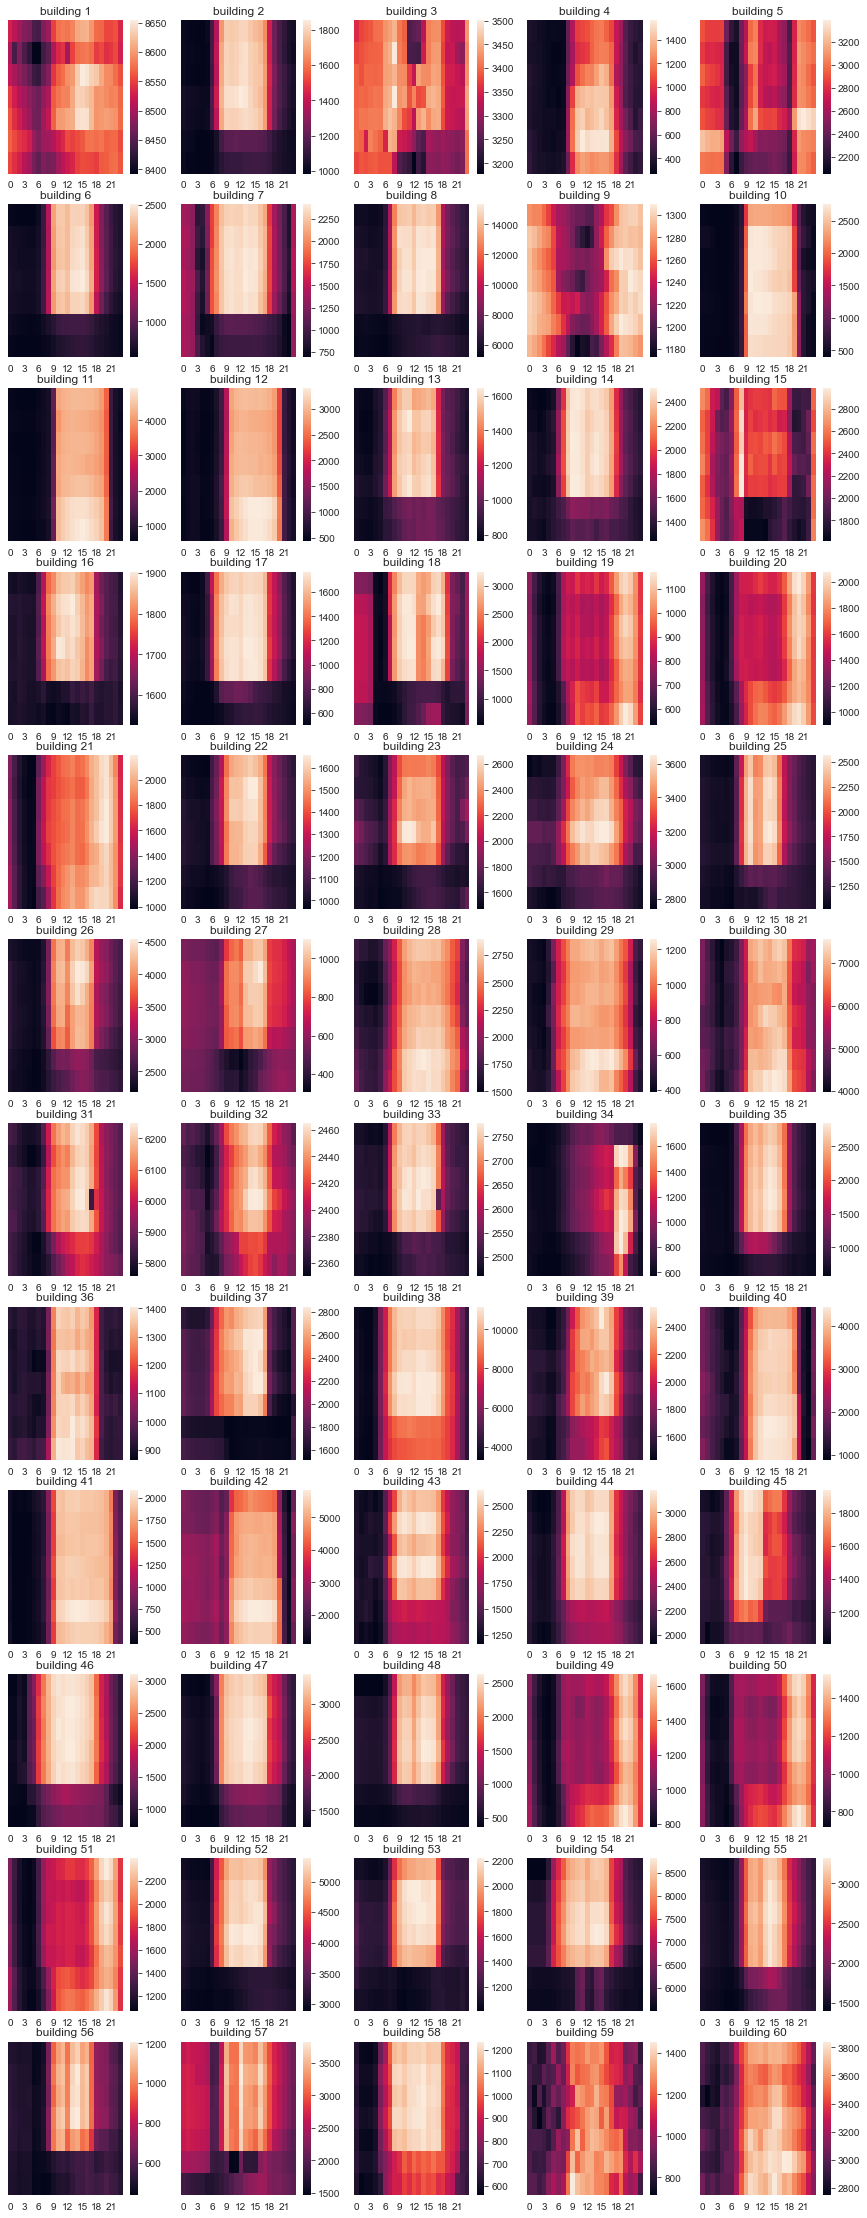

In [14]:
# 시간, 요일, 전체 timeline에 따라 건물별로 전력사용량 패턴을 살펴보기.

fig = plt.figure(figsize = (15, 40))
for num in eda_df['num'].unique():
    df = eda_df[eda_df.num == num]
    df = df.groupby(['weekday', 'hour'])['target'].mean().reset_index().pivot('weekday', 'hour', 'target')
    plt.subplot(12, 5, num)
    sns.heatmap(df)
    plt.title(f'building {num}')
    plt.xlabel('')
    plt.ylabel('')
    plt.yticks([])

1, 3, 5, 9번 건물처럼 사용 분포가 골고루 분포 되어 있거나,
2, 4, 6, 10번 건물처럼 낮부터 저녁 전까지 중점으로 사용 하거나,
19, 20, 21번 건물처럼 저녁부터 밤까지 사용하는 분포, 3가지 정도의 종류가 보인다.

헌데, 31번과 33번 건물에서 15~18시 사이에 급격히 낮은 사용량이 관측이 된다.
직접 csv파일 확인 결과, 2개 건물 동시에 같은 시간, 날짜에 나타났으므로 특정 외부 요인이 있었을 것이라 판단. 

In [15]:
# 군집화를 위한 건물을 기준으로 하는 data frame 생성
by_weekday = eda_df.groupby(['num','weekday'])['target'].median().reset_index().pivot('num','weekday','target').reset_index()
by_hour = eda_df.groupby(['num','hour'])['target'].median().reset_index().pivot('num','hour','target').reset_index().drop('num', axis = 1)
df = pd.concat([by_weekday, by_hour], axis= 1)
columns = ['num'] + ['day'+str(i) for i in range(7)] + ['hour'+str(i) for i in range(24)]
df.columns = columns

In [16]:
# '전력사용량'이 아닌 '요일과 시간대에 따른 전력 사용량의 경향성'에 따라서만 군집화 할 것이므로, 특수한 scaling이 필요함
# standard scaling
for i in range(len(df)):
    # 요일 별 전력 중앙값에 대해 scaling
    df.iloc[i,1:8] = (df.iloc[i,1:8] - df.iloc[i,1:8].mean())/df.iloc[i,1:8].std()
    # 시간대별 전력 중앙값에 대해 scaling
    df.iloc[i,8:] = (df.iloc[i,8:] - df.iloc[i,8:].mean())/df.iloc[i,8:].std()

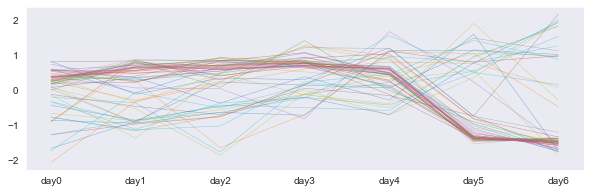

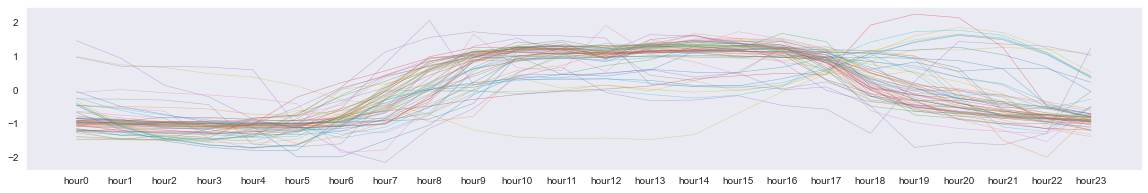

In [17]:
# 시각화
fig = plt.figure(figsize = (10,3))
for i in range(len(df)):
    plt.plot(df.iloc[i, 1:8], alpha = 0.5, linewidth = 0.5)
fig = plt.figure(figsize = (20,3))
for i in range(len(df)):
    plt.plot(df.iloc[i, 8:], alpha = 0.5, linewidth = 0.5)

In [19]:
import sklearn
from sklearn.cluster import KMeans

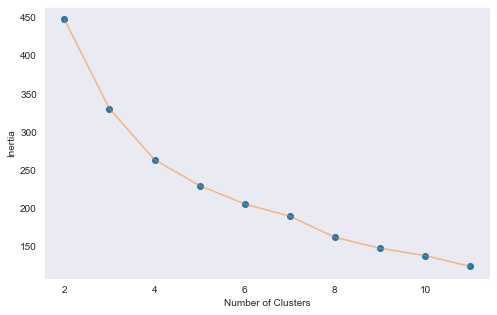

In [20]:
# elbow method를 통해 군집의 개수 결정
def change_n_clusters(n_clusters, data):
    sum_of_squared_distance = []
    for n_cluster in n_clusters:
        kmeans = KMeans(n_clusters=n_cluster)
        kmeans.fit(data)
        sum_of_squared_distance.append(kmeans.inertia_)
        
    plt.figure(1 , figsize = (8, 5))
    plt.plot(n_clusters , sum_of_squared_distance , 'o')
    plt.plot(n_clusters , sum_of_squared_distance , '-' , alpha = 0.5)
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')

change_n_clusters([2,3,4,5,6,7,8,9,10,11], df.iloc[:,1:])

In [21]:
#최적의 군집 수를 4개로 결정
kmeans = KMeans(n_clusters=4, random_state = 2)
km_cluster = kmeans.fit_predict(df.iloc[:,1:])

In [23]:
df_clust = df.copy()
df_clust['km_cluster'] = km_cluster
df_clust['km_cluster'] = df_clust['km_cluster'].map({0:1, 1:3, 2:2, 3:0})

In [25]:
eda_df = eda_df.merge(df_clust[['num','km_cluster']], on = 'num', how = 'left')

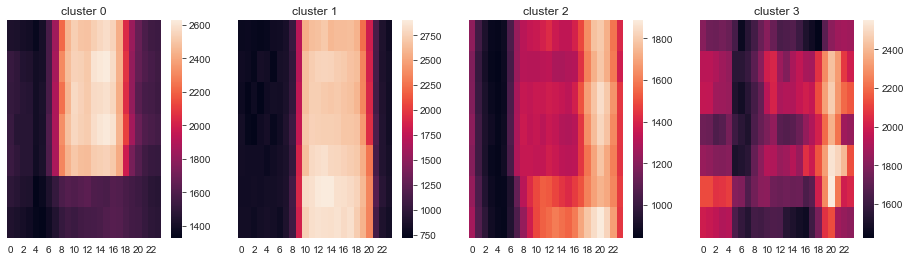

In [26]:
fig = plt.figure(figsize = (20, 4))
for c in range(4):
    temp = eda_df[eda_df.km_cluster == c]
    temp = temp.groupby(['weekday', 'hour'])['target'].median().reset_index().pivot('weekday', 'hour', 'target')
    plt.subplot(1, 5, c+1)
    sns.heatmap(temp)
    plt.title(f'cluster {c}')
    plt.xlabel('')
    plt.ylabel('')
    plt.yticks([])

4가지 군집 설명:

- cluster 0: 평일 주간에 전력소모가 크고, 
  평일야간이나 주말에는 전력소모가 작은 건물(사무실, 학교)
  
- cluster 1: 야간과 주간 전력소모 차이는 뚜렷하지만, 평일 주말 관계없이
  전력소모가 일정하거나 주말 전력소요가 조금 더 높은 건물(카페)
  
- cluster 2: 평일보다 주말에 전력소모가 크고, 
  낮보다 밤에 전력소모가 큰 건물(주점)
  
- cluster 3: 출근 전 시간대에 전력소모가 매우 낮고, 
  저녁이 될 수록 전력소모가 커진다.

추후에 할 일,

군집 별 건물 전력소요에 대한 분석

전력사용량과 다른 변수(기온, 습도, 태양관 설비 등등)의 상관 계수

당시 전력사용의 비용이나 불쾌지수를 이용한 분석

변수 중요도
